# Traffic Flow Optimization with XYmixer on QAOA
The traffic optimization problem is one of the most famous optimization problems in quantum computing.

## References
Traffic flow optimization using a quantum annealer  
Florian Neukart, Gabriele Compostella, Christian Seidel, David von Dollen, Sheir Yarkoni, Bob Parney   
https://arxiv.org/abs/1708.01625

## Example
Consider a network of 9 intersections and 12 streets.

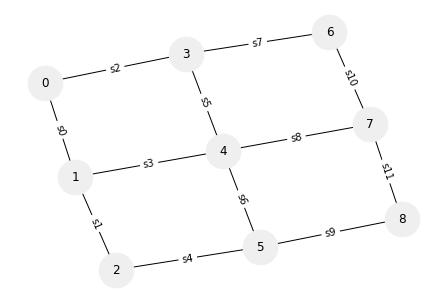

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from([i for i in range(9)])
G.add_edges_from([[0,1],(1,2),(0,3),(1,4),(2,5),(3,4),(4,5),(3,6),(4,7),(5,8),(6,7),(7,8)])
options = {'node_size': 1200,'with_labels':'True'}
pos = nx.spring_layout(G)
nx.draw(G, pos, **options, node_color='#efefef')

edge_labels={(0,1):'s0',(1,2):'s1',(0,3):'s2',(1,4):'s3',(2,5):'s4',(3,4):'s5',(4,5):'s6',(3,6):'s7',(4,7):'s8',(5,8):'s9',(6,7):'s10',(7,8):'s11'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

## 2 Cars and 3 possible routes for each car
Now there are two cars, going from point 0 to point 8. We propose three routes for each car to take, and consider the cost of each route to be counted as congestion if the cars take the same street. Then assign a qubit to each proposed route from Q0 to Q5.

route for car1  
Q0 : s0,s3,s8,s11  
Q1 : s2,s7,s10,s11  
Q2 : s0,s1,s4,s9  

route for car2  
Q3 : s0,s3,s8,s11  
Q4 : s2,s7,s10,s11  
Q5 : s0,s1,s4,s9  

## Calculation of congestion level
The level of congestion is determined by whether the street appears within the proposed route or not.　We can calculate the congestion for the roads from s0 to s11 and add them together to get the overall congestion level. For example, s0 appears in Q0, Q2, Q3, and Q5 of the proposed routes, so the cost is $(Q0+Q2+Q3+Q5)^2$. The whole cost is,

$$
H = (Q0+Q2+Q3+Q5)^2 + (Q2+Q5)^2 + (Q1+Q4)^2 + (Q0+Q3)^2 + (Q2+Q5)^2 + (Q1*Q4)^2 + (Q0+Q3)^2 + (Q2+Q5)^2 + (Q1+Q4)^2 + (Q0+Q1+Q3+Q4)^2
$$


In [2]:
from blueqat.pauli import qubo_bit as q

hamiltonian = (q(0)+q(2)+q(3)+q(5))**2 + (q(2)+q(5))**2 + (q(1)+q(4))**2 + (q(0)+q(3))**2 + (q(2)+q(5))**2 + (q(1)*q(4))**2 + (q(0)+q(3))**2 + (q(2)+q(5))**2 + (q(1)+q(4))**2 + (q(0)+q(1)+q(3)+q(4))**2

## Hard constraints
There is one constraint that must be observed here. That is the constraint that each car should choose only one route. This can be easily solved by using XYmixer. The XYmixer is a Hamiltonian that determines how the problem is explored; the search is performed in such a way that the 01 and 10 state vectors are swapped. Here, car 1 and car 2 choose only one of the three routes, so only one of the three qubits, Q0, Q1, Q2, will be 1 and the rest will be 0. Likewise, only one of the qubits Q3, Q4, and Q5 will be 1. To maintain this state, a mechanism for exchanging qubits, called 2opt, is used. For the initial state, choose any state that satisfies the constraints.

## Quantum Alternating Operator Ansatz

In [1]:
from blueqat import vqe, Circuit
from blueqat.pauli import X, Y

step = 4

#mixer and init state
mixer = 0.5*X[0]*X[1] + 0.5*Y[0]*Y[1] + 0.5*X[1]*X[2] + 0.5*Y[1]*Y[2] + 0.5*X[2]*X[0] + 0.5*Y[2]*Y[0]
mixer += 0.5*X[3]*X[4] + 0.5*Y[3]*Y[4] + 0.5*X[4]*X[5] + 0.5*Y[4]*Y[5] + 0.5*X[5]*X[3] + 0.5*Y[5]*Y[3]
init = Circuit(6).x[0].x[3]

result = vqe.Vqe(vqe.QaoaAnsatz(hamiltonian, step, init, mixer)).run()
result.most_common(10)

(((0, 1, 0, 0, 0, 1), 0.4434926334413086),
 ((0, 0, 1, 0, 1, 0), 0.4434926334413085),
 ((0, 1, 0, 1, 0, 0), 0.035112578038535035),
 ((1, 0, 0, 0, 1, 0), 0.035112578038535),
 ((0, 0, 1, 1, 0, 0), 0.014419387138927743),
 ((1, 0, 0, 0, 0, 1), 0.014419387138927736),
 ((0, 0, 1, 0, 0, 1), 0.007406870192776883),
 ((1, 0, 0, 1, 0, 0), 0.004346020684804994),
 ((0, 1, 0, 0, 1, 0), 0.002197911884856614),
 ((0, 1, 1, 0, 0, 1), 9.754608247073196e-32))

In the end, the combination of either Q2 and Q4 or Q1 and Q5 resulted in the least congestion. These solutions are considered correct because they do not go through the same road

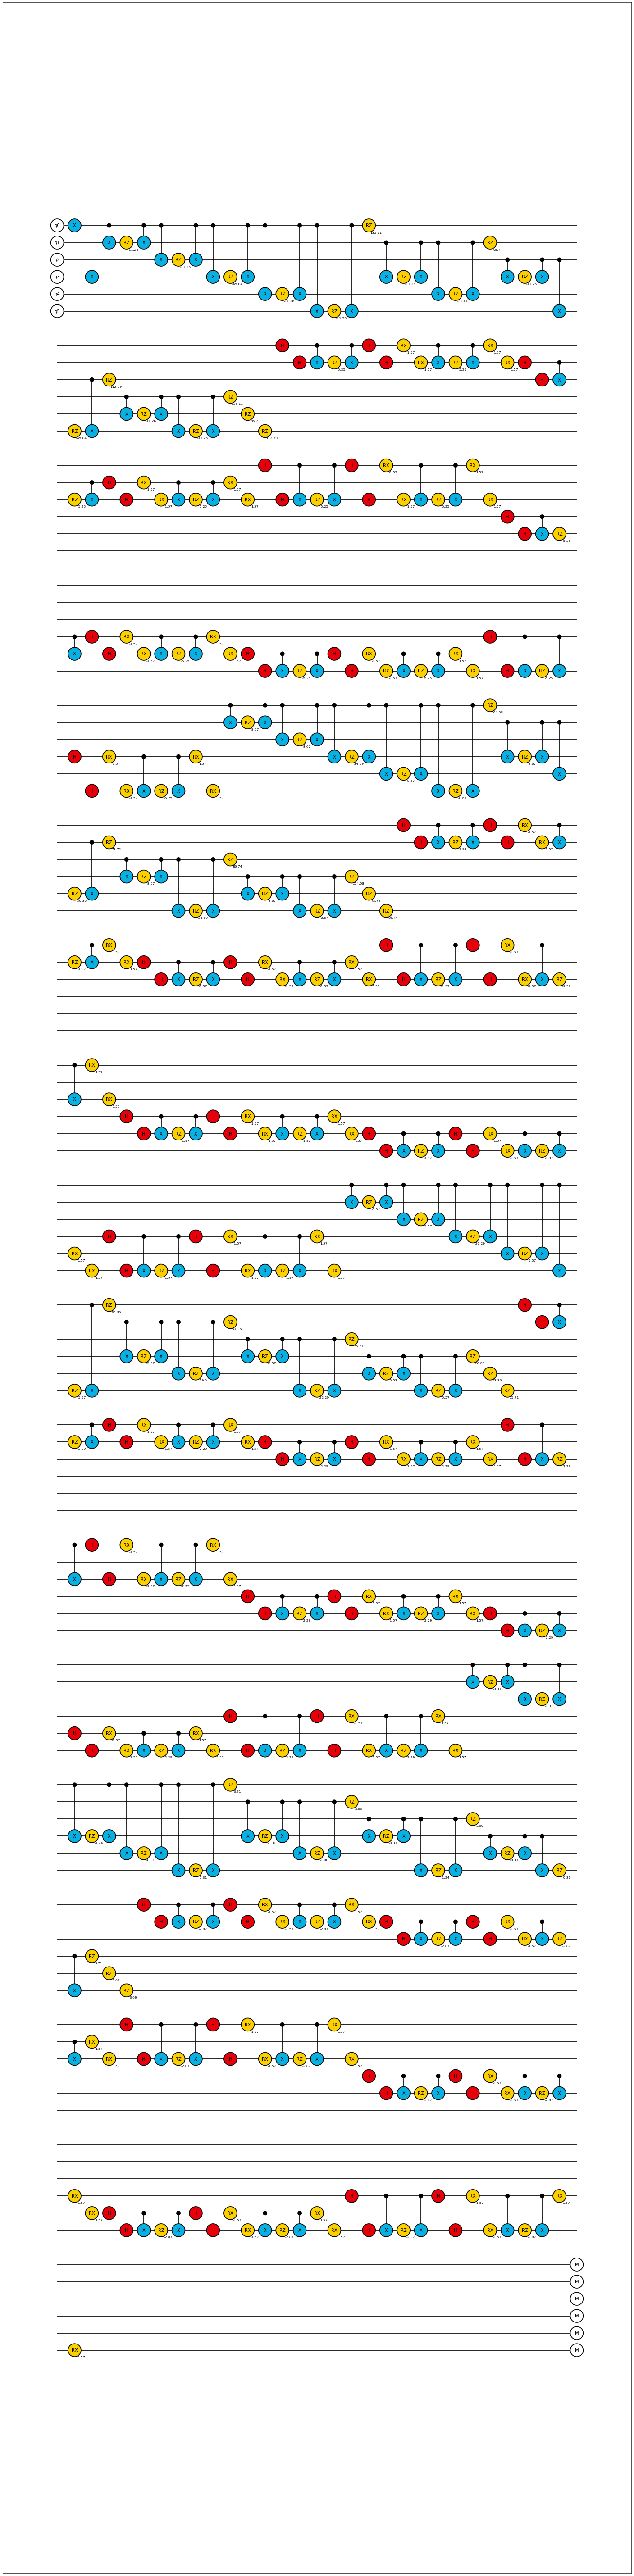

In [3]:
result.circuit.run(backend="draw")

## Solve using IonQ and Rigetti

In [4]:
from bqcloud import load_api
from blueqat import Circuit
from bqcloud import Device

api = load_api()

# Circuit, Device, Number of shots, Group name(Optional) for IonQ
task_ionq = api.execute(result.circuit, Device.IonQDevice, 10)

# Circuit, Device, Number of shots, Group name(Optional) for Rigetti
task_rigetti = api.execute(result.circuit, Device.Aspen11, 10)